<a href="https://colab.research.google.com/github/D3TaLES/In-The-Mix/blob/main/computation/InTheMix2_ComputationDay2_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to In the Mix: Computation Day 2! 

##**Recap**
1. **Types of DFT calculations**: Recall the three types of DFT calculations that we discussed yesterday. 

![](https://drive.google.com/uc?id=1p_GcfJeN8dUkMQHef1Yb9QWPKchpnFTa)

2. **Oxidation Potentials**: Ideal redox flow batteries have a high oxidation potential for the catholyte and a low reduction potential for the analyte. Because of this, it is important to be able to calculate the oxidation and reduction potentials for a potential redox flow battery material. 

![](https://drive.google.com/uc?id=1bm3LO-JQH7VF8xyCgdjmzJr-OI_T5_I_)



## Setup

In [ ]:
#@markdown Import needed modules
import os
import json
import copy
import warnings
import hashlib
import requests
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#@markdown Class for Pulling Data from D3TaLES Database
# REST API class

USERNAME = 'd3tales.edu@gmail.com'
PASSWORD = 'D3education'

class RESTAPI(object):
    def __init__(self, method=None, url="https://d3tales.as.uky.edu", endpoint=None,
                 login_endpoint='login', username=USERNAME, password=PASSWORD,
                 upload_file=None, params=None, expected_endpoint=None, return_json=False):
        """
        Upload a file to through d3tales.as.uky.edu file upload feature.

        :param method: str, html method (such as post or get)
        :param url: str, base url
        :param endpoint: str, post or get endpoint url (not containing base url)
        :param login_endpoint: str, login url (not containing base url)
        :param username: str, user username
        :param password: str, user password
        :param upload_file: str, path to file to be uploaded
        :param params: dict, form parameters for post
        :param return_json: bool, get or post method returns json if true
        """
        self.method = method
        self.endpoint = "{}/{}/".format(url, endpoint).replace("//", "/").replace(':/', '://')
        self.login_endpoint = "{}/{}/".format(url, login_endpoint).replace("//", "/").replace(':/', '://')
        if expected_endpoint:
            self.expected_endpoint = "{}/{}/".format(url, expected_endpoint).replace("//", "/").replace(':/', '://')
        self.user_data = dict(username=username, password=password) if username and password else None
        
        self.client = self.get_client()
        params.update(dict(csrfmiddlewaretoken=self.csrftoken, next='/')) if params else {}
        self.params = params or {}
        self.upload_file = upload_file
        self.return_json = return_json

        if self.method in ["get", "GET", "Get"]:
            self.response = self.get_process()

        elif self.method in ["POST", "post", "Post"]:
            self.response = self.post_process()

        if expected_endpoint:
            if self.response.request.url != self.expected_endpoint:
                warnings.warn("The {} response url for {} to {} did not match the expected response url".format(
                    self.upload_file, self.endpoint, self.method))
        
    @property
    def cookies(self):
        return self.client.get(self.endpoint).cookies  # sets cookie

    @property
    def csrftoken(self):
        # Retrieve the CSRF token for data post
        return self.cookies['csrftoken'] if 'csrftoken' in self.cookies else self.cookies['csrf']

    def get_client(self):
        with requests.Session() as client:
            if self.login_endpoint and self.user_data:
                # Login
                client.get(self.login_endpoint)  # sets cookie
                csrftoken = client.cookies['csrftoken'] if 'csrftoken' in client.cookies else client.cookies['csrf']
                self.user_data.update(dict(csrfmiddlewaretoken=csrftoken, next='/'))
                # Submit login form
                req = client.post(self.login_endpoint, data=self.user_data, headers=dict(Referer=self.login_endpoint))
            return client

    def post_process(self):
        # Submit data form
        file_data = dict(file=open(self.upload_file, 'rb')) if self.upload_file else None
        req = self.client.post(self.endpoint, data=self.params, files=file_data,
                               headers=dict(Referer=self.endpoint), cookies=self.cookies)
        return_data = req.json() if self.return_json else req
        return return_data

    def get_process(self):
        if self.params:
            req = self.client.get(self.endpoint, data=self.params, headers=dict(Referer=self.endpoint), cookies=self.cookies)
        else:
            req = self.client.get(self.endpoint, headers=dict(Referer=self.endpoint))

        return_data = req.json() if self.return_json else req
        return return_data


## Computation of standard reduction potentials 

### Theory
This material is adapted from the [MolSSI Quantum Mechanics Tools workshop](https://education.molssi.org/qm-tools/05-redox/index.html).

For a molecule to be a candidate for battery application, it needs to store energy by gaining and loosing electrons during charge-discharge process. The measure of the ease with which a molecule will gain or lose electrons in solution is termed reduction potential. In order to apply computational chemistry to find candidate molecules for batteries, being able to compute reduction potentials for molecular species is incredibly important.

In order to compute a reduction potential, it is important to understand the basic physical principles of this quantity. For example, take this half-reaction that involves the benzoquinone molecule:

![](https://drive.google.com/uc?id=1o9N_Wus5Zo-S_PWYEa2XqiX-Vw9uxt6j)


The reduction potential is related to the Gibbs free energy of the half reaction as:

![](https://drive.google.com/uc?id=1PlJjWelyUz48-MMIJCtr0kqI-ESqRuk2)

Here, Eº is the reduction potential corresponding to the quantity that the experiment measures. This is the potential (voltage) of an electrode surface where reactant and product are in equilibrium. More negative potentials correspond to higher energy electrons needed to reduce the reactant.

∆G<sub>red</sub> is the free energy change of the reduction half-reaction in solution, where the electron comes from the vacuum, and the molecules are in solution. n is the number of electrons transferred (in our case, n = 1) and F is the Faraday constant; its value is exactly 1 eV/V and serves to convert units of energy (in eV) into units of potential (V).

The electrons in the experiment do not come from vacuum, but from an electrode whose potential is measured relative to a reference electrode. We choose to use the normal hydrogen electrode as a reference, where the energy of the electrons is –4.43 V relative to the vacuum, thus we subtract this value from our answer.

Now that we have seen the physical principles, we would like to obtain computationally and this would allow us to predict a reduction potential.The Gibbs free energy of reduction, and can be computed as a free energy difference: 

∆G<sub>red</sub> = G(A–) – G(A)

where G(●) is the Gibbs free energy of a species in solution. Computationally, this is broken down into several contributions:
$$ G = E_{SCF} + \Delta G_{solv} + H - TS $$

The first two terms and represent the ground-state electronic energy plus the solvation free energy term. These two terms are computed together as the ground-state energy when running a Psi4 energy calculation in implicit solvent. The equilibrium (minimum energy) structure should be used, but you don’t necessarily need to use implicit solvent, or even the same functional or basis set to perform the minimization, as long as you remain consistent for the oxidized and reduced species.

The calculation of ∆G<sub>red</sub> can be visualized with the following Born-Haber cycle diagram: 

![](https://drive.google.com/uc?id=1-KtcQjjuTwx3c7tZrqjrLHkrcVX3kiKz)

H – TS represent the enthalpy and entropy terms in the Gibbs free energy. We will approximate these terms by treating the molecule as having three translational and three rotational degrees of freedom, and represent all of the internal motions using harmonic oscillators. The translational contributions to H and S come from known formulas for the ideal gas, the rotational contributions use a rigid rotor approximation that takes information from the molecular geometry, and the vibrational contribution requires a harmonic frequency calculation (including the zero point vibration). The frequency analysis calculation in Psi4 provides all of this information.

Summary of the calculation procedure
In summary, here are the steps for computing the reduction potential:



*   For the neutral molecule, follow these steps to compute the Gibbs free energy:
  1.   Calculate an energy minimized structure.
  2.   Calculate the harmonic free energy correction at the energy minimized structure.
  3.   Calculate the ground state energy plus ∆Gsolv from implicit solvent.
  4.   Add the results from (2) and (3) to get the free energy of the species.
*   Repeat the above steps for the anion radical.
*   Calculate ∆G<sub>red</sub> = G(A–) – G(A). This should be a negative number because most molecules in solvent are able to accommodate an additional electron.
*   Convert this energy to eV by multiplying your quantity (in a.u.) by 27.211.
*   Multiply by –1 and subtract 4.43 to obtain the reduction potential w/r.t. NHE.


In this exercise, we will study neutral benzoquinone and the benzoquinone anion to calculate the reduction potential.

### Hands On Calculations

In [ ]:
#@markdown Functions for pulling reduction potential data from D3TaLES database
def get_calculation_value(data_list, calculation_type, prop_name): 
  data = [d for d in data_list if d.get("calculation_type") == calculation_type][0]
  return data.get('data', {}).get(prop_name, {}).get('value')

def get_oxidation_data(_id):
  response = RESTAPI(method='get', endpoint="restapi/molecules/_id={}/mol_characterization.redox_potential=1/".format(_id),
                      url="https://d3tales.as.uky.edu", login_endpoint='login',
                      return_json=True).response[0]
  hash_ids = response.get("redox_potential")[0].get("source_hash_ids")
  data_list = []
  for hash_id in hash_ids: 
    hash_response = RESTAPI(method='get', endpoint="restapi/rawdata/computation/_id="+hash_id, 
                          url="https://d3tales.as.uky.edu", login_endpoint='login', 
                          return_json=True).response[0]
    data_list.append(hash_response)

  data_dict =  {'neutral_energy_gas': get_calculation_value(data_list, "opt_groundState", "scf_total_energy"), 
          'neutral_energy_solv': get_calculation_value(data_list, "solv_energy_gsgs", "scf_total_energy"), 
          'neutral_correction': get_calculation_value(data_list, "freq_groundState", "gibbs_correction"), 
          'cation_energy_gas': get_calculation_value(data_list, "opt_cation1", "scf_total_energy"), 
          'cation_energy_solv': get_calculation_value(data_list, "solv_energy_c1c1", "scf_total_energy"), 
          'cation_correction': get_calculation_value(data_list, "freq_cation1", "gibbs_correction"), 
        }
  return pd.Series(data_dict, name=_id)

def get_reduction_data(_id):
  data_list = RESTAPI(method='get', endpoint="restapi/rawdata/computation/mol_id="+_id, 
                      url="https://d3tales.as.uky.edu", login_endpoint='login', 
                      return_json=True).response

  data_dict =  {'neutral_energy_gas': get_calculation_value(data_list, "opt_groundState", "scf_total_energy"), 
          'neutral_energy_solv': get_calculation_value(data_list, "solv_energy_gsgs", "scf_total_energy"), 
          'neutral_correction': get_calculation_value(data_list, "freq_groundState", "gibbs_correction"), 
          'anion_energy_gas': get_calculation_value(data_list, "opt_anion1", "scf_total_energy"), 
          'anion_energy_solv': get_calculation_value(data_list, "solv_energy_a1a1", "scf_total_energy"), 
          'anion_correction': get_calculation_value(data_list, "freq_anion1", "gibbs_correction"), 
        }
  return pd.Series(data_dict, name=_id)

∆G<sub>red</sub> = G(A–) – G(A)

where 
G(A) = **Minimized E (gas)** + **Free energy correction (gas)** +	 + **Delta G Solvation**

In [ ]:
# Pull computational data for benzoquinone
data = get_reduction_data("80WQZA")
data

neutral_energy_gas    -10365.118819
neutral_energy_solv   -10365.319482
neutral_correction         1.555866
anion_energy_gas      -10366.919873
anion_energy_solv     -10369.170794
anion_correction           1.503212
Name: 80WQZA, dtype: float64

In [ ]:
# How to access data
print("Neutral energy (gas): \t", data.neutral_energy_gas)
print("Anion energy (solv): \t", data.anion_energy_solv)

Neutral energy (gas): 	 -10365.118818898596
Anion energy (solv): 	 -10369.170793505189


In [ ]:
# computing free energy for neural species
neutral_free_energy = 0 # write your equation here

In [ ]:
#@markdown SOLUTION
neutral_free_energy = data.neutral_energy_gas + data.neutral_correction + (data.neutral_energy_solv - data.neutral_energy_gas)

In [ ]:
# computing free energy for anionic (-1) species
anion_free_energy = 0 # write your equation here

In [ ]:
#@markdown SOLUTION
anion_free_energy = data.anion_energy_gas + data.anion_correction + (data.anion_energy_solv - data.anion_energy_gas)

In [ ]:
# redox potential
redox_potential = 0 # write your equation here

In [ ]:
#@markdown SOLUTION
redox_potential = -(anion_free_energy - neutral_free_energy) / 1 - 4.43

In [ ]:
print(redox_potential)

-0.5260345382627563


### Compare Redox Potentials of multiple quinones 

In [ ]:
#@markdown Write function for reduction potential
def get_redox_potential(_id, number_electrons=1): 
  data = get_reduction_data(_id)
  neutral_free_energy = data.neutral_energy_gas + data.neutral_correction + (data.neutral_energy_solv - data.neutral_energy_gas)
  anion_free_energy = data.anion_energy_gas + data.anion_correction + (data.anion_energy_solv - data.anion_energy_gas)
  redox_potential = -(anion_free_energy - neutral_free_energy) / number_electrons - 4.43
  return redox_potential

In [ ]:
quinones_ids = {'benzoquinone': '80WQZA',  'naphthoquinone': '80JNKV',  'duroquinone': '06OSYU'}

rp_benzoquinone = get_redox_potential('80WQZA')
rp_naphthoquinone = get_redox_potential('80JNKV')
rp_duroquinone = get_redox_potential('06OSYU')

print("rp_benzoquinone: \t", rp_benzoquinone)
print("rp_naphthoquinone: \t", rp_naphthoquinone)
print("rp_duroquinone: \t", rp_duroquinone)

rp_benzoquinone: 	 -0.5260345382627563
rp_naphthoquinone: 	 -0.753495964221365
rp_duroquinone: 	 -0.8967416718730234


Text(0, 0.5, 'Computational Potential')

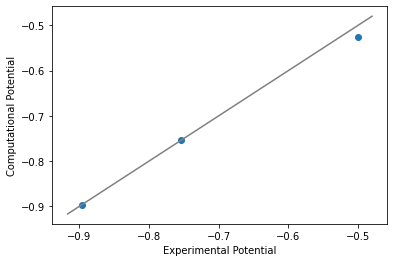

In [ ]:
#@markdown Compare calculated reduction potentials with experimental. Enter YOUR experimental results!
rp_benzoquinone_exp = -0.5 #@param {type: "number"}
rp_naphthoquinone_exp = -0.7 #@param {type: "number"}
rp_duroquinonee_exp = -0.8 #@param {type: "number"}

# Plot computational vs experimental 
import matplotlib.pyplot as plt
plt.scatter([rp_benzoquinone_exp, rp_naphthoquinone, rp_duroquinone], 
            [rp_benzoquinone, rp_naphthoquinone, rp_duroquinone])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='gray')
plt.xlabel("Experimental Potential")
plt.ylabel("Computational Potential")


### Try it Yourself! 
You can find the molecule ID for molecules in the D<sup>3</sup>TaLES database by searching the D<sup>3</sup>TaLES [Database website](https://d3tales.as.uky.edu/database/search_results/)!

In [ ]:
# Feel free to use this cell to try getting the computed redox potentials for other molecules


## Big Data Analysis

In [ ]:
#@title Functions for Processing Pulled Data from D3TaLES Database
def get_value(prop_list, value_key="value", _id='?', avoid_duplicates=False): 
  if not prop_list: 
    return None
  if avoid_duplicates and len(prop_list) != 1: 
    print("There are more than one redox potential values for {}".format(_id))
    return None
  try: 
    return prop_list[0][value_key]
  except KeyError: 
    print("There is not a redox potential value for {}".format(_id))

def get_redox(source_group=None, limit=500): 
  if source_group: 
    query = "mol_info.source_group={}/mol_characterization.oxidation_potential=1/limit={}".format(source_group, limit)
  else: 
    query = "{}/mol_characterization.oxidation_potential=1/limit=" + str(limit)
  response = RESTAPI(method='get', endpoint="restapi/molecules/"+query, 
                     url="https://d3tales.as.uky.edu", login_endpoint='login',
                     return_json=True).response

  comp_data = pd.DataFrame(response)
  comp_data.rename(columns={'oxidation_potential': 'oxidation_list'}, inplace=True)

  comp_data['oxidation_potential'] = comp_data.apply(lambda x: get_value(x.oxidation_list, _id=x._id), axis=1)
  comp_data.dropna(inplace=True)

  comp_data.set_index(comp_data._id, inplace=True)
  comp_data.drop(['oxidation_list', '_id' ], axis=1, inplace=True)
  
  return comp_data

def get_mos(calc_type='opt_groundState', limit=500): 
  response = RESTAPI(method='get', endpoint="restapi/rawdata/computation/calculation_type="+calc_type+"/{}/limit="+str(limit), 
                     url="https://d3tales.as.uky.edu", login_endpoint='login', 
                     return_json=True).response
  response_data = pd.json_normalize(response, max_level=2)
  all_data = pd.DataFrame(response_data)

  all_data.rename(columns={'{}.data.homo': 'homo', '{}.data.lumo': 'lumo', '{}.mol_id': 'mol_id'}, inplace=True)
  all_data.set_index(all_data.mol_id, inplace=True)
  comp_data = all_data[['homo', 'lumo']]

  comp_data.dropna(inplace=True)
  comp_data['homo'] = all_data.apply(lambda x: x.homo.get('value') if isinstance(x.homo, dict) else None, axis=1)
  comp_data['lumo'] = all_data.apply(lambda x: x.lumo.get('value')if isinstance(x.lumo, dict) else None, axis=1)
  comp_data.dropna(inplace=True)
  
  return comp_data


In [ ]:
# Get molecular orbitals (HOMOs and LUMOs) form backend DB 
mo_df = get_mos()
# Get oxidation potentials from frontend DB 
redox_df = get_redox()

# Merge two dataframes by molecular id (indexes)
master_df = pd.merge(mo_df, redox_df, left_index=True, right_index=True)
master_df

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-20-f5a2e638bb52>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_data['homo'] = all_data.apply(lambda x: x.homo.get('value') if isinstance(x.homo, dict) else None, axis=1)
<ipython-input-20-f5a2e638bb52>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,homo,lumo,oxidation_potential
05AWCY,-6.699447,0.406810,1.150070
05BCMO,-7.306261,0.069389,0.901049
05CKZO,-6.287738,0.559466,0.741025
05DIRJ,-11.870429,-5.268127,1.555521
05DIRJ,-13.857678,-3.931231,1.555521
...,...,...,...
90ZXAR,-7.308710,1.959493,0.211076
90ZXAR,-7.303812,1.954867,0.211076
90ZXAR,-7.299458,1.951057,0.211076
90ZYYG,-7.316057,0.521643,1.388501


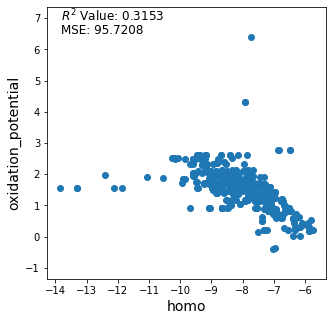

In [ ]:
#@title Seeing Trends in Data

#@markdown The Born-Haber cycle describes the change in energy as a molecule undergoes a redox reaction, which can be either a reduction or an oxidation reaction. <br />

#@markdown In this section, we will be focusing on just oxidation reactions.

#@markdown $\Delta G_{soln, ox}$ = $\Delta G_{gas}^{\circ}$  + $\Delta G_{ox, soln}^{\circ}$ - $\Delta G_{red, soln}^{\circ}$<br />

#@markdown The $\Delta G_{ox, soln}^{\circ}$ term is well-correlated with the HOMO energy of a molecule due to Koopmans' Theorem - which states that the oxidation potential is equal to the negative value of the HOMO energy of a molecule.<br />

#@markdown So, this implies that the oxidation potential is related to the HOMO energy of the molecule, but due to the $\Delta G_{gas}^{\circ}$  and the $\Delta G_{red, soln}^{\circ}$ terms, this is not an exact correlation. <br /><br />
#@markdown In the graph below, we're looking at the relationship between the HOMO energy values and oxidation potential.

x_data = 'homo'
y_data = 'oxidation_potential'

fig, ax = plt.subplots(1, figsize=(5,5), facecolor='w')
ax.scatter(master_df[x_data], master_df[y_data])
ax.set_title('', fontsize=20)
ax.set_xlabel(x_data, fontsize=14)
ax.set_ylabel(y_data, fontsize=14)
ax.axis('equal')
r2_value = stats.linregress(master_df[x_data], master_df[y_data])[2] **2
mse = mean_squared_error(master_df[x_data], master_df[y_data])
ax.text(0.05, 0.95, "$R^2$ Value: {:.4f}".format(r2_value), transform=ax.transAxes, fontsize=12)
ax.text(0.05, 0.9, "MSE: {:.4f}".format(mse), transform=ax.transAxes, fontsize=12)
ax.set_xlim(plt.xlim())
ax.set_ylim(plt.ylim())
# Plot reference line 
ax.plot([-1000,1000], [-1000, 1000], 'k')

In [ ]:
#@markdown There is a linear correlation between these two values, but the $r^2$ value is reduced by the outliers. Likewise, because the $\Delta G_{ox, soln}^{\circ}$ is related to the negative value of the HOMO energy, the correlation is negative. <br /><br />
#@markdown So, from these outliers, it can be infered that the $\Delta G_{gas}^{\circ}$  and the $\Delta G_{red, soln}^{\circ}$ terms can cause the oxidation potential of a molecule to be much different than the negative of that molecule's HOMO energy value.<br /><br />


In [ ]:
#@markdown While understanding the relationship between HOMO energy and oxidation potential is fairly straightfoward, there are also non-linear relationship that also have an effect on the HOMO energy and the oxidation potential relationship. For instance there are many properties - such as ring size, ring type, molecular weight, atom type, etc. - that play a role in redox potential.

#@markdown In these cases, machine learning can be used to illustrate the relationship between data and features. 


## **Synopsis**

## **1. Calculate redox potential with the Born-Haber cycle**

![](https://drive.google.com/uc?id=1-KtcQjjuTwx3c7tZrqjrLHkrcVX3kiKz)

![](https://drive.google.com/uc?id=1PlJjWelyUz48-MMIJCtr0kqI-ESqRuk2)


Computationally, calculating the redox potential would look like: 
```
neutral_free_energy = neutral_energy_gas + neutral_correction + (neutral_energy_solv - neutral_energy_gas)
anion_free_energy = anion_energy_gas + anion_correction + (anion_energy_solv - anion_energy_gas)
redox_potential = -(anion_free_energy - neutral_free_energy) / 1 - 4.43

```


## **2. Compare calculated with experimentally measured reduction potentials**


## **3. View big data trends between E<sup>&deg;</sup><sub>ox</sub> and HOMO**
This relationship is generally linear, but not perfect. So, we still need more acurate methods for estimating redox potential (like computation and machine learning). 

Copyright 2021-2023, University of Kentucky and University of Iowa

Designed by Rebekah Duke and Amelia Sweet